In [1]:
from corr_grid import nsq_grid, fluxes_grid, get_data, regplot_log_wrap, parse_err_map, flux_prep, _dist_col
from regplotter import fill_between
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

# sns.set(style="ticks", context="talk")
# plt.style.use("dark_background")
mpl.rcParams['figure.dpi'] = 120

### Notes about iSHELL dataset 

All spectra data is for CO

CO line kinematics have been found in previous work to reflect projection effects and the formation of an inner dust cavity, with line FWHM larger for higher disk inclinations (e.g. Blake & Boogert 2004) and FWHM smaller for larger n$_{13-30}$ (e.g. Salyk et al. 2011a).

### Notes on this notebook

My dataset has no way of telling which FWHM and centroids it should use.
For VISIR and CRIRES it would be able to tell from the zero uncertainties, but that is not the case here.
I need to be able to detect FWHM and Centroid outliers (due to flux upper limit) early in the grid creation process.

In [2]:
dataset = pd.read_csv('../../Data/iSHELL_outputs_merged.csv', sep=',', skipinitialspace=True, na_values=['#NAME?'])
dataset.sample(n=5, random_state=0)

,NAME,COMP,S_PAR_TOT,FW10,V1_CEN,V1_FWHM,V1_FLUX,V1_FLUX_ERR,V1H_CEN,V1H_FWHM,...,FNIR_REF,INCL,INCL_ERR,INCL_REF,W2_JY,RDUSTNIR,RDUSTNIR_ERR,RDUST_REF,RSUBLEMPIR,RNIR_COMB
29,RYTau,NC,3.763824,200.80,7.22289,54.2658,6.100000e-15,1.350000e-16,12.1488,70.8542,...,Garufi(privcomm),65.0,0.1,Long+2018,NaN,0.340000,0.030000,Perraut+2021,0.225481,0.340000
11,HD36917,SC,1.705882,159.50,17.47500,106.6500,1.770000e-14,2.270000e-16,28.5750,119.6500,...,Garufi(privcomm),89.4,19.3,Lazareff+2017,2.742450,0.117057,0.060116,Lazareff+2017,0.639156,0.117057
10,HD35929,SC,1.937824,149.60,16.32500,122.2500,1.960000e-14,2.200000e-16,21.4000,121.4000,...,Garufi(privcomm),31.8,16.2,Lazareff+2017,1.110040,0.211840,0.042848,Lazareff+2017,0.411520,0.211840
22,CITau,NC,4.682456,266.90,22.22500,104.6500,3.560000e-14,6.300000e-16,22.2250,104.6500,...,Garufi+2018,50.0,0.1,Long+2018,0.659689,NaN,NaN,NaN,0.121892,0.121892
2,HD142666,SC,1.293528,70.95,-3.45000,55.7000,2.540000e-15,1.150000e-16,-8.1000,50.6000,...,Garufi+2018,55.9,2.8,Perraut+2019,3.040460,0.105502,0.018918,Perraut+2019,0.232529,0.105502


In [3]:
# Generating masks

# COMPONENTS
"""
Broad component “BC” dominates the line wings and a narrow component “NC” dominating the line center
Abs stands for absorption. 

Double-peak lines usually display a single component “SC”, 
i.e. lines from different isotopologues and vibrational levels all have similar shape and width
"""
single_comp = dataset['COMP'] == 'SC'
broad_comp = dataset['COMP'] == 'BC'
narrow_comp = dataset['COMP'] == 'NC'
abs_comp = dataset['COMP'] == 'abs'

v1ul_mask = dataset['V1_FLUX_ERR'] > dataset['V1_FLUX'] 
v2ul_mask = dataset['V2_FLUX_ERR'] > dataset['V2_FLUX'] 

In [4]:
error_map = parse_err_map(dataset)
error_map

{'V1_FLUX': 'V1_FLUX_ERR',
 'V1H_FLUX': 'V1H_FLUX_ERR',
 'V2_FLUX': 'V2_FLUX_ERR',
 'I13_FLUX': 'I13_FLUX_ERR',
 'TEFF': 'TEFF_ERR',
 'RV': 'RV_ERR',
 'INCL': 'INCL_ERR',
 'RDUSTNIR': 'RDUSTNIR_ERR'}

['TEFF', 'MSTAR', 'LSTAR', 'LOGLACC', 'LOGMACC', 'N1330', 'V1_Lum'] {'TEFF': 'TEFF_ERR', 'V1_Lum': 'V1_Lum_ERR'}


Creating Grid:   0%|                                                                                                                                    | 0/6 [00:01<?, ?subplot/s]


EOFError: 

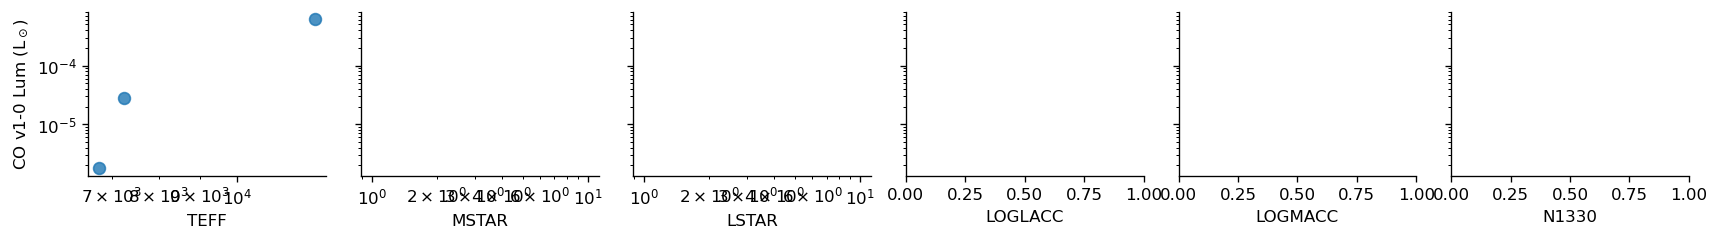

In [6]:
nc_all = dataset[narrow_comp].copy()

xvars = ['TEFF', 'MSTAR', 'LSTAR', 'LOGLACC', 'LOGMACC', 'N1330']
log_vars = ['V1_FLUX', 'V1_FLUX_CORR', 'MSTAR', 'LSTAR', 'TEFF', 'V1H_FLUX', 'V2_FLUX']
labels_map = {'V1_FLUX': 'CO v1-0 Lum (L$_\odot$)',
              'V1H_FLUX': 'CO v1H-0H Lum (L$_\odot$)',
              'V2_FLUX': 'CO v2-1 Lum (L$_\odot$)'}

yvars = ['V1_FLUX']
delta_map = flux_prep(nc_all, y_vars=yvars, log_vars=log_vars, labels_map=labels_map, correction_col='W2_JY')
g, error_map = nsq_grid(nc_all, x_vars=xvars, y_vars=yvars, log_vars=log_vars, delta_map=delta_map,
                        labels_map=labels_map, ann_coeff=False, copy=False, qrange=(0, 1))

# yvars = ['V1H_FLUX']
# delta_map = flux_prep(sc_all, y_vars=yvars, log_vars=log_vars, labels_map=labels_map, correction_col='W2_JY')
# g, error_map = nsq_grid(sc_all, x_vars=xvars, y_vars=yvars, log_vars=log_vars, delta_map=delta_map,
#                         labels_map=labels_map, ann_coeff=False, copy=False, qrange=(0, 1), grid=g)

In [13]:
(delta_map['V1_Lum'] == 0).value_counts()

False    50
True      1
dtype: int64

In [7]:
delta_map.keys()

dict_keys(['V1_Lum', 'V1H_Lum', 'V2_Lum', 'I13_Lum'])

In [5]:
v1det_subset = dataset[~v1ul_mask].copy()
v2det_subset = dataset[~v2ul_mask].copy()

In [6]:
v1sc_dets = dataset[single_comp & (~v1ul_mask)].copy()
v1sc_dets['V1_FLUX_CORR'] = v1sc_dets['V1_FLUX'] * v1sc_dets['W2_JY']
v1sc_dets['V1_FLUX_CORR_ERR'] = v1sc_dets['V1_FLUX_ERR'] * v1sc_dets['W2_JY']

v1sc_dets['V1_CEN_CORR'] = v1sc_dets['V1_CEN'] - v1sc_dets['RV'] 

In [7]:
yvars = ['V1_FLUX_CORR', 'V1_FWHM', 'V1_CEN_CORR']
xvars = ['TEFF', 'MSTAR', 'LSTAR', 'LOGLACC', 'LOGMACC', 'N1330']
log_vars = ['V1_FLUX', 'V1_FLUX_CORR', 'MSTAR', 'LSTAR', 'TEFF']
labels_map = {'V1_FLUX_CORR': 'CO Lum (L$_\odot$)',
             'V1_FWHM': 'CO FWHM (km/s)',
             'V1_CEN_CORR': 'CO Cen (km/s)'}
delta_map = flux_prep(v1sc_dets, xvars, yvars, log_vars, labels_map=labels_map)

In [8]:
# quantiles = v1sc_dets.quantile(q=[0.0, 0.1, 1.0])
# quantiles.loc[1.0] =(quantiles.loc[0.1] - quantiles.loc[0]) + quantiles.loc[1.0]
# quantiles.drop(index=[0.1])['TEFF']
# quantiles.loc[1.0]
# quantiles.loc[1.0]
# quantiles.loc[1.0]
# (quantiles.loc[0.1] - quantiles.loc[0.1])['TEFF']

# v1sc_dets.index
# v1sc_dets.loc[1.0] = v1sc_dets.loc[1.0] + v1sc_dets.loc[0.01]
# v1sc_dets

['TEFF', 'MSTAR', 'LSTAR', 'LOGLACC', 'LOGMACC', 'N1330', 'V1_Lum_CORR', 'V1_FWHM', 'V1_CEN_CORR'] {'TEFF': 'TEFF_ERR', 'V1_Lum_CORR': 'V1_Lum_CORR_ERR'}


Creating Grid: 100%|██████████████████████████████████████████████████████████████| 18/18 [02:11<00:00,  7.29s/subplot]


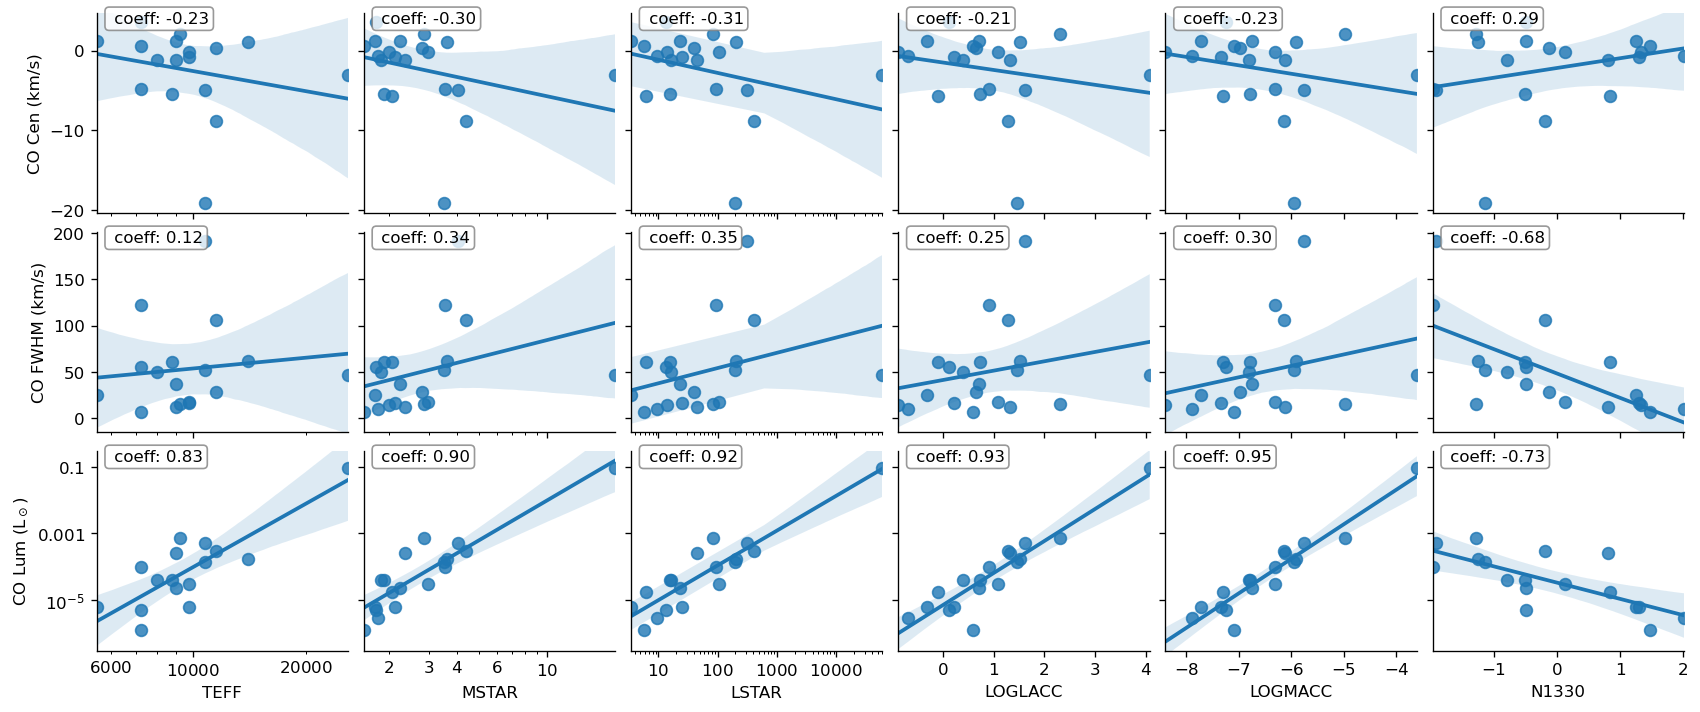

In [9]:
# delta_map = flux_prep(v1sc_dets, xvars, yvars, log_vars, labels_map=labels_map)
# err_map = {'TEFF': 'TEFF_ERR', 'V1_Lum_CORR': 'V1_Lum_CORR_ERR'}
g, error_map = nsq_grid(v1sc_dets, xvars, yvars, log_vars=log_vars, delta_map=delta_map, error_map=err_map,
                        labels_map=labels_map, ann_coeff=True, copy=False, qrange=(0, 1))
# plt.gcf().savefig('COV1_fluxes.pdf')

Change FWHM view to log scale

['TEFF', 'MSTAR', 'LSTAR', 'LOGLACC', 'LOGMACC', 'N1330', 'V1_FWHM'] {'TEFF': 'TEFF_ERR'}


Creating Grid: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:45<00:00,  7.52s/subplot]


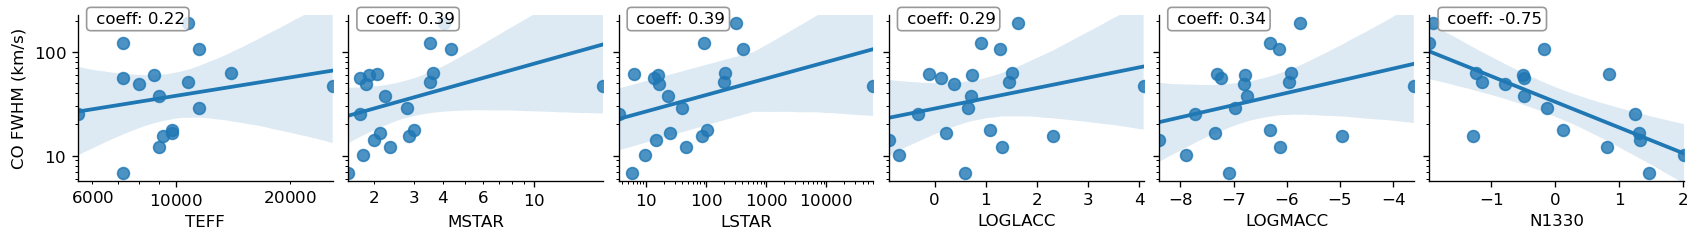

In [10]:
log_vars2 = log_vars + ['V1_FWHM']
# delta_map = flux_prep(v1sc_dets, xvars, yvars, log_vars, labels_map=labels_map)
g, error_map = nsq_grid(v1sc_dets, xvars, ['V1_FWHM'], log_vars=log_vars2, delta_map=delta_map, 
                        labels_map=labels_map, ann_coeff=True, copy=False, qrange=(0, 1))
# plt.gcf().savefig('COV1_fluxes_v2.pdf')

In [11]:
sc_subset = dataset[single_comp].copy()

sc_subset['V1_FLUX_CORR'] = sc_subset['V1_FLUX'] * sc_subset['W2_JY']
sc_subset['V1_FLUX_CORR_ERR'] = sc_subset['V1_FLUX_ERR'] * sc_subset['W2_JY']
sc_subset['V1_CEN_CORR'] = sc_subset['V1_CEN'] - sc_subset['RV'] 


yvars = ['V1_FLUX_CORR', 'V1_FWHM', 'V1_CEN_CORR']
xvars = ['TEFF', 'MSTAR', 'LSTAR', 'LOGLACC', 'LOGMACC', 'N1330']
log_vars = ['V1_FLUX', 'V1_FLUX_CORR', 'MSTAR', 'LSTAR', 'TEFF']
labels_map = {'V1_FLUX_CORR': 'CO Lum (L$_\odot$)',
             'V1_FWHM': 'CO FWHM (km/s)',
             'V1_CEN_CORR': 'CO Cen (km/s)'}
delta_map = flux_prep(sc_subset, xvars, yvars, log_vars, labels_map=labels_map)
any(delta_map['V1_Lum_CORR'] == 0)

False

In [12]:
# v1sc_dmap